In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

# Load the Drive helper and mount
drive.mount('/content/drive')

# Python Folder path
PYTHON_PATH = '/content/drive/MyDrive/Computer/Python/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


What you can find here:
 - Under/Over Sampling
 - Feature Engineering
 - Feature Selection
   - Correlation
   - Featuretools
   - AUC Score
   - SelectKBest
   - SelectFromModel
   - Decision Tree
 - Machine Learning
   - Association Rules
   - Classification
   - Regression
   - Unsupervised
   - Model Interprataion - Lime & SHAP
 - AI Network
   - Simple
   - Deep Learning


#### *Data*

In [ ]:
%%capture
# Data for Classification
var_targetY_class, binary_class = 'overall_rating', []
cols = ['product_name', 'product_brand', 'site_category_lv1', 'site_category_lv2',
        'review_title', 'recommend_to_a_friend', 'reviewer_birth_year',
        'reviewer_gender', 'reviewer_state']
data_ml_class = pd.read_csv(PYTHON_PATH+'data/train_df.csv')[cols+[var_targetY_class]]
data_ml_class[var_targetY_class].replace(5,0,inplace=True)
for col in cols:
  data_ml_class.loc[:,col] = LabelEncoder().fit_transform(data_ml_class.loc[:,col])
for value in data_ml_class[var_targetY_class]:
  if value==3 or value==0: binary_class.append(0)
  else: binary_class.append(1)
data_ml_class[var_targetY_class+'Binary'] = binary_class

# Binary or Multi classes
def get_data_class(binary):
  if binary:
    data = data_ml_class.drop([var_targetY_class], axis=1)
    var_class = var_targetY_class+'Binary'
  else:
    data = data_ml_class.drop([var_targetY_class+'Binary'], axis=1)
    var_class = var_targetY_class
  return data, var_class

NameError: ignored

In [ ]:
# Data for Regression
cols = ['GrLivArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass','SalePrice']
data_ml_reg = pd.read_csv(PYTHON_PATH+'data/house_prices_train.csv')[cols]
data_ml_reg.fillna(data_ml_reg.median())
var_targetY_reg = 'SalePrice'

## *Under n Over Sampling*

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.10, 0.20, 0.70],
                           class_sep=0.8, random_state=0)
pd.Series(y).value_counts()

2    3485
1    1010
0     505
dtype: int64

In [ ]:
#OverSampling

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_new, y_new = SMOTE().fit_resample(X, y) #same for `ADASYN()`

X_new, y_new = RandomOverSampler(random_state=0).fit_resample(X, y)

In [ ]:
#UnderSampling

from imblearn.under_sampling import EditedNearestNeighbours, AllKNN, RandomUnderSampler

X_new, y_new = EditedNearestNeighbours().fit_resample(X, y) #same for `AllKNN()`

X_new, y_new = RandomUnderSampler(random_state=0).fit_resample(X, y)

In [ ]:
#Mix of both
from imblearn.combine import SMOTEENN, SMOTETomek

X_new, y_new = SMOTETomek(random_state=0).fit_resample(X, y) #same for `SMOTEENN()`

In [ ]:
pd.Series(y_new).value_counts()

1    887
0    100
dtype: int64

## *Feature Engineering*

In [ ]:
# Min Max Scaler  ---  transf. to [0,1]
##  preserve de shape n doesn’t meaningfully change the information
##  Good place to start, unless you want feature with normal dist or
##    you want to reduce influence of some outliers
##  z = (x - min(x)) / (max(x) - min(x))
##  has a inverse: `norm.inverse_transform(scale_data)`

from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
#scale.fit_transform(df.loc[:,'Round 1':'Round 3'])
scale.fit_transform(df.loc[:,'Round 1'].values.reshape(-1,1)) #or `df[['Round 1']]`

array([[0.04262877],
       [0.05506217],
       [0.        ],
       [0.05328597],
       [0.00236827],
       [1.        ],
       [0.0491415 ],
       [0.07104796]])

In [ ]:
# Normalizer  ---  transf. to [-1,1] --- acts per row
##  by default ('l1') each element are squared and summed - the total would equal 1
##  has a inverse: `norm.inverse_transform(data)`

from sklearn.preprocessing import Normalizer

norm = Normalizer()
norm.fit_transform(df.loc[:,'Round 1':'Round 2'])
#norm.fit_transform(df.loc[:,'Round 1'].values.reshape(-1,1)) #or `df[['Round 1']]`

In [ ]:
# StandardScaler / Z-Score  ---  mean~=0 and std=1
##  z = (x - mean) / total
##  has a inverse: `scaler.inverse_transform(data)`

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#scaler.fit_transform(df.loc[:,'Round 1':'Round 3'])
scaler.fit_transform(df.loc[:,'Round 1'].values.reshape(-1,1)) #or `df[['Round 1']]`

## *Feature Selection*

### Correlation

#### with target variable

In [ ]:
feature_corr = pd.DataFrame(data_ml_reg.corr(method='pearson')[var_targetY_reg]) #or kendall, spearman
feature_corr['corr_abs'] = feature_corr[var_targetY_reg].apply(lambda x: x if x>0 else abs(x))
feature_corr.columns = ['corr','corr_abs']
feature_corr.sort_values(by='corr_abs',ascending=False,inplace=True)

threshold = 0.7
feature_corr['corr'] = feature_corr['corr'].apply(lambda x: x if x>threshold else 'None')
feature_corr = feature_corr[feature_corr['corr'] != 'None']

data_ml_reg[feature_corr.index].head(1)

,SalePrice,GrLivArea
0,208500,1710


#### between the features themselfs


Delete features with correlation bigger than *threshold*

In [ ]:
import numpy as np
threshold = 0.7
def remove_predictor_correlated(data):
  print(f'Initial features: {len(data.columns)}')

  # Get correlation df and list of flags for each col
  corr = data.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)

  # Set False for cols that exceeds the threshold
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
      if corr.iloc[i,j] >= threshold:
        if columns[j]:
          columns[j] = False

  # Select features
  selected_columns = data.columns[columns]
  data = data[selected_columns]

  print(f'Final features: {len(data.columns)}')

  return data

remove_predictor_correlated(data_ml_reg.drop(var_targetY_reg, axis=1)).head(1)

Initial features: 28
Final features: 25


,GrLivArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass
0,1710,706,0,150,856,854,0,1,0,2,...,0,61,0,0,0,0,0,2,2008,60


### Featuretools

In [ ]:
%%capture

pip install featuretools

In [ ]:
from sklearn.datasets import load_iris
import featuretools as ft
import pandas as pd

# Load data and put into dataframe
data = ft.demo.load_mock_customer()
df_customers = data['customers']
df_sessions = data['sessions']
df_transactions = data['transactions']
df_products = data['products']

# Make an entityset - contain entities and relationships
es = ft.EntitySet('Sales')

# Add the entity - the data to be processed
es.add_dataframe(dataframe_name='customers', dataframe=df_customers, index='customer_id', time_index = 'join_date')
es.add_dataframe(dataframe_name='sessions', dataframe=df_sessions, index='session_id', time_index='session_start')
es.add_dataframe(dataframe_name='transactions', dataframe=df_transactions, index='transaction_id', time_index='transaction_time')
es.add_dataframe(dataframe_name='products', dataframe=df_products, index='product_id')

# Build the relationships - like in RDBMS
new_relat = ft.Relationship(es, 'customers', 'customer_id', 'sessions', 'customer_id')
es.add_relationship(relationship=new_relat)
es.add_relationship('sessions', 'session_id', 'transactions', 'session_id')
es.add_relationship('products', 'product_id', 'transactions', 'product_id')
print(es)

# Run deep feature synthesis with transformation primitives - create new features
features, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'customers',
                                 agg_primitives = ['mean', 'sum', 'mode'],
                                 trans_primitives = ['month','hour'], #transform existing information into new data
                                 max_depth = 2)
                                 #list of primitives: ft.list_primitives()
print("Feature list:")
for feature in feature_names:
  print(feature)

Entityset: Sales
  DataFrames:
    customers [Rows: 5, Columns: 4]
    sessions [Rows: 35, Columns: 4]
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
  Relationships:
    sessions.customer_id -> customers.customer_id
    transactions.session_id -> sessions.session_id
    transactions.product_id -> products.product_id
Feature list:
<Feature: MODE(sessions.device)>
<Feature: MEAN(transactions.amount)>
<Feature: MODE(transactions.product_id)>
<Feature: SUM(transactions.amount)>
<Feature: HOUR(birthday)>
<Feature: HOUR(join_date)>
<Feature: MONTH(birthday)>
<Feature: MONTH(join_date)>
<Feature: MEAN(sessions.MEAN(transactions.amount))>
<Feature: MEAN(sessions.SUM(transactions.amount))>
<Feature: MODE(sessions.HOUR(session_start))>
<Feature: MODE(sessions.MODE(transactions.product_id))>
<Feature: MODE(sessions.MONTH(session_start))>
<Feature: SUM(sessions.MEAN(transactions.amount))>
<Feature: MODE(transactions.sessions.device)>


### AUC score

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# variables
numFeaturesInCombination = 5
numCombinations = 400
numBestSingleFeaturesToSelectFrom = 20

# split data
BINARY = False
data_class, var_class = get_data_class(binary=BINARY)
X = data_class.drop([var_class], axis=1)
y = data_class[[var_class]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# get features names n create df with response - all combination
featuresNameToUse = X.iloc[0,0:numBestSingleFeaturesToSelectFrom-1].index
featureColumnNames = ['feature'+str(x+1) for x in range(numFeaturesInCombination)]
featureCombinationsTable = pd.DataFrame(index=range(numCombinations),
                                        columns=featureColumnNames + ['combinedAUC'])

In [ ]:
%%capture

for combination in range(numCombinations):
  # generate combination of 5 features
  randomSelectionOfFeatures = sorted(np.random.choice(len(featuresNameToUse),
                                                      numFeaturesInCombination,
                                                      replace=False))

  # get features names
  combinationFeatureNames = [featuresNameToUse[x] for x in randomSelectionOfFeatures]

  # add the features name into the df with the response
  for featureIndex, featureName in enumerate(combinationFeatureNames):
    featureCombinationsTable.iloc[combination,featureIndex] = featureName

  # get the correct features values
  trainInputFeatures = X_train[combinationFeatureNames]
  validInputFeatures = X_val[combinationFeatureNames]

  # treinar o modelo
  modelCombination = LogisticRegression()
  modelCombination.fit(trainInputFeatures, y_train)

  # calcula e guarda os resultados da AUC
  if BINARY:
    pred = modelCombination.predict(validInputFeatures)
    validAUC = auc(y_val, pred)
  else:
    pred_proba = modelCombination.predict_proba(validInputFeatures)
    validAUC = auc(y_val, pred_proba, multi_class='ovr')
  featureCombinationsTable.iloc[combination,-1] = validAUC

  # output metadata
  print(f'Feature Combination {combination}: {randomSelectionOfFeatures}')
  print(f'Feature Names from Combination {combination}: {combinationFeatureNames}')
  print(f'AUC Score of: {validAUC}')
  print('----------------------------------------------------------------------------------------------------------------------------------')

In [ ]:
validAUC = np.array(featureCombinationsTable.loc[:,'combinedAUC'])
print("(min,max) AUC = (%.4f,%.4f)." % (validAUC.min(),validAUC.max()))

# mostra as 20 melhores combinações
featureCombinationsTable = featureCombinationsTable.sort_values(by='combinedAUC', axis=0,
                                                                ascending=False).reset_index(drop=True)
featureCombinationsTable.iloc[:20,:]

# pegando as TOP 5
feature = []
for i in range(5):
  feature.append(featureCombinationsTable.iloc[i,:].values)
feature

(min,max) AUC = (0.5160,0.7463).


[array(['site_category_lv1', 'recommend_to_a_friend',
        'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
        0.7463350317263847], dtype=object),
 array(['site_category_lv1', 'recommend_to_a_friend',
        'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
        0.7463350317263847], dtype=object),
 array(['site_category_lv2', 'recommend_to_a_friend',
        'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
        0.6800162280925545], dtype=object),
 array(['site_category_lv2', 'recommend_to_a_friend',
        'reviewer_birth_year', 'reviewer_gender', 'reviewer_state',
        0.6800162280925545], dtype=object),
 array(['site_category_lv1', 'site_category_lv2', 'recommend_to_a_friend',
        'reviewer_birth_year', 'reviewer_gender', 0.6795057872865644],
       dtype=object)]

### SelectKBest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Problem type - mdl can change
is_class = True
if is_class: #Classification problems
  data, var_targetY = get_data_class(binary=False)
  func = f_classif
  mdl = LogisticRegression()
  def metric(y_test, y_pred): return {'Metrics': accuracy_score(y_test, y_pred)}
else: # Regression problems
  var_targetY = var_targetY_reg
  func = f_regression
  mdl = LogisticRegression()
  data = data_ml_reg
  def metric(y_test, y_pred): return {'Metrics': mean_squared_error(y_test, y_pred)}

# Split data
X = data.drop(var_targetY, axis=1)
y = data[[var_targetY]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
%%capture

# run ~ n_rows times
k_vs_score = []
for k in range(2,X_train.shape[1]+1):
  # create and training the selector
  selector = SelectKBest(score_func=func, k=k)
  Xtrain2 = selector.fit_transform(X_train, y_train)
  Xval2 = selector.transform(X_test)

  # create and training the model - depend from the problem
  mdl.fit(Xtrain2, y_train)
  y_pred = mdl.predict(Xval2)

  #save metrics to see later
  errors = metric(y_test, y_pred)
  errors['k'] = k
  k_vs_score.append(errors)

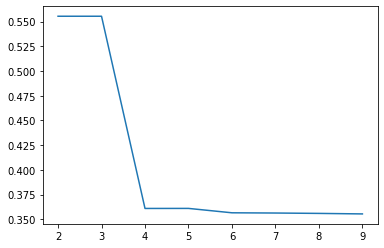

In [ ]:
#define result df, the plot and the measure to look
k_errors = pd.DataFrame(k_vs_score).set_index('k')
plt.plot(k_errors)

In [ ]:
# train with best k and get col names
best_k = k_errors.sort_values('Metrics', ascending=False).index[0]
selector = SelectKBest(score_func=func, k=best_k)
selector.fit(X, y)
list(X.iloc[:, selector.get_support()].columns)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['product_brand', 'recommend_to_a_friend']

### SelectFromModel

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

In [ ]:
# Problem type
is_class = True
if is_class: #Classification problems
  data, var_targetY = get_data_class(binary=False)
  func = f_classif
  mdl = LogisticRegression()
  def metric(y_test, y_pred): return {'Metrics': accuracy_score(y_test, y_pred)}
else: # Regression problems
  var_targetY = var_targetY_reg
  func = f_regression
  mdl_selector = Lasso(alpha=0.08885877289587728, normalize=True)
  mdl = Lasso(alpha=0.08885877289587728, normalize=True)
  data = data_ml_reg
  def metric(y_test, y_pred): return {'Metrics': mean_squared_error(y_test, y_pred)}

# Split data
X = data.drop(var_targetY, axis=1)
y = data[[var_targetY]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
%%capture

k_vs_score = []
for k in range(2, X_train.shape[1], 2):
  # build and fit selector - transform the data
  selector = SelectFromModel(mdl_selector, max_features=k, threshold=-np.inf)
  selector.fit(X_train, y_train)
  Xtrain2 = selector.transform(X_train)
  Xval2 = selector.transform(X_test)

  # train and predict with Selector data
  mdl.fit(Xtrain2, y_train)
  y_pred = mdl.predict(Xval2)

  for i in range(len(y_pred)):
    if y_pred[i] < 0:
      y_pred[i] = abs(y_pred[i])

  # save metrics
  errors = metric(y_test,y_pred)
  errors['k'] = k
  k_vs_score.append(errors)

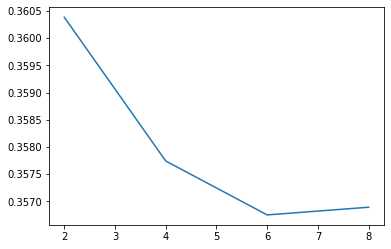

In [ ]:
#define result df, the plot and the measure to look
k_errors = pd.DataFrame(k_vs_score).set_index('k')
plt.plot(k_errors)

In [ ]:
# train with best k and get col names
best_k = k_errors.sort_values('Metrics', ascending=False).index[0]
selector = SelectFromModel(mdl_selector, max_features=best_k, threshold=-np.inf)
selector.fit(X_train, y_train)
list(X_train.iloc[:, selector.get_support()].columns)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


['product_name', 'product_brand']

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Problem type
is_class = False
if is_class: #Classification problems
  data, var_targetY = get_data_class(binary=False)
  mdl = RandomForestClassifier()
else: # Regression problems
  var_targetY = var_targetY_reg
  data = data_ml_reg
  mdl = DecisionTreeRegressor()

# Split data
X = data.drop(var_targetY, axis=1)
y = data[[var_targetY]]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# train model
mdl.fit(X, y)

# get importance of each feature
importance = mdl.feature_importances_

In [ ]:
# creating a dict with the feature importance
feature_importance = {}
for i, feature in enumerate(features):
    feature_importance[feature] = round(importance[i], 3)

feature_importance

{'product_name': 0.217,
 'product_brand': 0.1,
 'site_category_lv1': 0.003,
 'site_category_lv2': 0.011,
 'review_title': 0.087,
 'recommend_to_a_friend': 0.029,
 'reviewer_birth_year': 0.04,
 'reviewer_gender': 0.0,
 'reviewer_state': 0.002}

In [ ]:
# get just importance feature
features = X.columns
im_bool = importance < 0.03
cols = list(features[im_bool].values)
cols.append(var_targetY)
df = data[cols]

## *Machile Learning*

### Association Rules

##### With List of tuples

In [ ]:
%%capture
!pip install efficient_apriori

In [ ]:
import pandas as pd
from efficient_apriori import apriori

In [ ]:
# Get data - each row is a transaction
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]

In [ ]:
# Create the rules
itemsets, rules = apriori(transactions, min_support=0.2, min_confidence=1)

In [ ]:
# Prints the rule desc
for rule in rules:
  print(rule)
  #print(rule.lhs)  #items on the left hand side
  #print(rule.rhs)  #items on the right hand side
  #print(rule.lift) #rule lift - same for confidence, support

{apple} -> {bacon} (conf: 1.000, supp: 0.333, lift: 1.000, conv: 0.000)
{apple} -> {eggs} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{banana} -> {bacon} (conf: 1.000, supp: 0.333, lift: 1.000, conv: 0.000)
{eggs} -> {bacon} (conf: 1.000, supp: 0.667, lift: 1.000, conv: 0.000)
{soup} -> {bacon} (conf: 1.000, supp: 0.667, lift: 1.000, conv: 0.000)
{banana} -> {soup} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{apple, eggs} -> {bacon} (conf: 1.000, supp: 0.333, lift: 1.000, conv: 0.000)
{apple, bacon} -> {eggs} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{apple} -> {bacon, eggs} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{banana, soup} -> {bacon} (conf: 1.000, supp: 0.333, lift: 1.000, conv: 0.000)
{bacon, banana} -> {soup} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{banana} -> {bacon, soup} (conf: 1.000, supp: 0.333, lift: 1.500, conv: 333333333.333)
{eggs, soup} -> {bacon} (conf: 1.000, supp: 0.333, 

##### With Dataframe

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# Data
data = pd.read_excel(PYTHON_PATH+'data/OnlineRetail.xlsx')

# Data clean
data['Description'] = data['Description'].str.strip() #stripping extra spaces
data.dropna(axis = 0, subset =['InvoiceNo'], inplace = True) #drop nan values - transaction id
data['InvoiceNo'] = data['InvoiceNo'].astype('str')
data = data[~data['InvoiceNo'].str.contains('C')] #drop cancellation transactions

In [ ]:
# Create baskets - df with the transactions
  # with InvoiceNo/TransactionId in axis x
  # with Description/ItemName in axis y
  # with Quantity as values, it'll be encode to 0 (not present) or 1 (present)

basket_France = (data[data['Country'] =="France"]
		.groupby(['InvoiceNo', 'Description'])['Quantity']
		.sum().unstack().reset_index().fillna(0)
		.set_index('InvoiceNo'))

basket_UK = (data[data['Country'] =="United Kingdom"]
		.groupby(['InvoiceNo', 'Description'])['Quantity']
		.sum().unstack().reset_index().fillna(0)
		.set_index('InvoiceNo'))

basket_Por = (data[data['Country'] =="Portugal"]
		.groupby(['InvoiceNo', 'Description'])['Quantity']
		.sum().unstack().reset_index().fillna(0)
		.set_index('InvoiceNo'))

basket_Sweden = (data[data['Country'] =="Sweden"]
		.groupby(['InvoiceNo', 'Description'])['Quantity']
		.sum().unstack().reset_index().fillna(0)
		.set_index('InvoiceNo'))

In [ ]:
# Hot Encoder - algorithm only accept: True, False, 0, 1
def hot_encode(x):
	if(x<= 0): return 0
	if(x>= 1): return 1

# Encoding the datasets
basket_France = basket_France.applymap(hot_encode)
#basket_UK = basket_UK.applymap(hot_encode)
#basket_Por = basket_Por.applymap(hot_encode)
#basket_Sweden = basket_Sweden.applymap(hot_encode)

In [ ]:
# Building the model
frq_items = apriori(basket_France, min_support = 0.05, use_colnames = True)

# Put results in a df - metric and min_threshold 'll define which rule 'll be include (a filter)
rules = association_rules(frq_items, metric = "lift", min_threshold = 1)

# Sort and print
rules = rules.sort_values(['confidence', 'lift'], ascending = [False, False])
print(rules)

                                           antecedents  \
45                        (JUMBO BAG WOODLAND ANIMALS)   
258  (PLASTERS IN TIN CIRCUS PARADE, RED TOADSTOOL ...   
270  (RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...   
300  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...   
301  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...   
..                                                 ...   
36                                           (POSTAGE)   
26                                           (POSTAGE)   
97                                           (POSTAGE)   
226                                          (POSTAGE)   
215                                          (POSTAGE)   

                                           consequents  antecedent support  \
45                                           (POSTAGE)            0.076531   
258                                          (POSTAGE)            0.051020   
270                                          (POSTAGE)            0.0

### Classification

In [ ]:
import pytz
import pandas as pd
import numpy as np
from random import uniform
from datetime import datetime

# Models Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Tuning Hyperparameters
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score as auc
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Split Data
from sklearn.model_selection import train_test_split

In [ ]:
# Variables

## ml variables
BINARY = True
data_ml, var_targetY = get_data_class(binary=BINARY)
overall_results = pd.DataFrame()
#overall_results = pd.read_excel(PYTHON_PATH+'data/Result_ML_Class.xlsx')


## Metadata - techniques applied into the data in any part
##  always is a string - if more than one, values separeted by ,
##  None is for nothing was done

### Prepocessing
outliers    = None #'None' -- 'IQR' -- 'ZScore'
delCol_type = None #'None' -- 'CstCols' -- 'DuplicateCols'
miss_values = None #'None' -- 'Fill' -- 'Fill with ...' -- 'Drop'
encode_type = None #'None' -- 'Label' -- 'OneHot' -- 'Binarization'
scale_type  = None #'None' -- 'MinMaxScaler' -- 'Normalizer' -- 'ZScore'
sampling    = None #'None' -- 'SMOTE_Over' -- 'EditedNearestNeighbours_Under'

### machine learning
cross_valid = None #'None' -- 'Yes'
tuning_type = None #'None' -- 'Random' -- 'Grid'
feature_eng = None #'None' -- 'Correlation' -- 'Featuretools' -- 'AUC Score' -- 'SelectKBest' -- 'SelectFromModel' -- 'Tree'

deleted_col = [] #list of col that was deleted - depend on the service

In [ ]:
def metrics(y_val, y_pred, pred_proba):

  # Confusion Matrix metrics
  conf = confusion_matrix(y_val, y_pred)

  # specific metrics
  if BINARY:
    tn, fp, fn, tp = conf.ravel()
    sens = tp / tp+fn
    spec = tn / (fp + tn)
    acc  = (tp+tn) / (tn+fp+fn+tp)
    prec = tp / (tp+fp)
    f1   = (2*prec*sens) / (prec+sens)

    spec_metrics = {'Conf TrueNeg--FalsePos--FalseNeg--TruePos': str(tn)+'--'+str(fp)+'--'+str(fn)+'--'+str(tp),
                    'Conf Sensibility': sens, 'Conf Accuracy': acc, 'Conf Precision': prec, 'Conf F1Score': f1}
    spec_metrics['ROC AUC'] = auc(y_val, y_pred)
    spec_metrics['Precision Score'] = precision_score(y_val, y_pred)
    spec_metrics['Recall Score'] = recall_score(y_val, y_pred)
    spec_metrics['F1 Score'] = f1_score(y_val, y_pred)
  else:
    spec_metrics = {'ROC AUC': auc(y_val, pred_proba, multi_class='ovr')}
    spec_metrics['Precision Score'] = precision_score(y_val, y_pred, average='macro')
    spec_metrics['Recall Score'] = recall_score(y_val, y_pred, average='macro')
    spec_metrics['F1 Score'] = f1_score(y_val, y_pred, average='macro')

  classes = y_val[var_targetY].unique()
  ddf = pd.DataFrame(conf, index=classes, columns=classes)

  spec_metrics['Accuracy Score'] = accuracy_score(y_val, y_pred)

  # general per class
  geral_report = classification_report(y_val, y_pred, output_dict=True)

  return {**geral_report, **spec_metrics}

In [ ]:
def model_train(model, data, var_targetY):
  # Get test and train data
  X = data.drop(var_targetY, axis=1)
  y = data[[var_targetY]]
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

  # Train the model
  model.fit(X_train, y_train)

  # Get measures
  pred = model.predict(X_val)
  pred_proba = model.predict_proba(X_val)
  param = model.get_params()
  results = metrics(y_val, pred, pred_proba)

  # Agg results
  results['YVal'] = '--'.join([str(val[0]) for val in y_val.values])
  results['Predict'] = '--'.join([str(p) for p in pred])

  return pd.DataFrame(results, index=[0]), param

In [ ]:
# Tuning Parameters

def separate_target(data):
  X = data.drop(var_targetY, axis=1)
  y = data[var_targetY]
  return X, y

def tuning_random(data,model, param_dist):
  X, y = separate_target(data)
  clf = RandomizedSearchCV(model, param_dist)
  search = clf.fit(X, y)
  return search.best_params_

def tuning_grid(data, model, param_dist):
  X, y = separate_target(data)
  clf = GridSearchCV(model, param_dist)
  search = clf.fit(X, y)
  return search.get_params

def tuning_parameters(data, model, param_dist, type_tuning):
  if type_tuning == 'Random':
    return tuning_random(data, model, param_dist)
  elif type_tuning == 'Grid':
    return tuning_grid(data, model, param_dist)

In [ ]:
#%%capture

# Compute a model for each algorithm, also tunning its parameters
methods = ['logistica_reg']#, 'naiveBayes', 'randomForest', 'svc', 'lgbm', 'xgb']

for method in methods:
  print(f'Doing {method} ...')

  if method=='logistica_reg':
    model = LogisticRegression()
    if tuning_type != None:
      param_dist = dict(C=list(range(1,20,0.3)), # when bigger, less the model is regularized
                        penalty=['l2', 'l1', 'elasticnet', None],
                        solver=['newton-cg', 'sag', 'saga', 'lbfgs'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = LogisticRegression(C=params['C'],    #new paramaters
                                 penalty=params['penalty'],
                                 solver=params['solver'])

  elif method =='naiveBayes':
    model = GaussianNB()
    if tuning_type != None:
      param_dist = dict(var_smoothing=np.logspace(0,-9, num=100))
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = LogisticRegression(var_smoothing=params['var_smoothing'])

  elif method=='randomForest':
    model = RandomForestClassifier()
    if tuning_type != None:
      param_dist = dict(n_estimators=list(range(50,500,20)),
                        criterion=['gini','entropy','log_loss'],
                        min_samples_splitint=list(range(0,4,0.2)),
                        min_samples_leafint=list(range(0,2,0.1)),
                        max_features=['sqrt','log2',None])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = RandomForestClassifier(n_estimators=params['n_estimators'],
                                     criterion=params['criterion'],
                                     min_samples_splitint=params['min_samples_splitint'],
                                     min_samples_leafint=params['min_samples_leafint'],
                                     max_features=params['max_features'])

  elif method=='svc':
    model = SVC()
    if tuning_type != None:
      param_dist = dict(C=uniform(loc=0, scale=4),
                        kernel=['linear','rbf','sigmoid'],
                        gamma=['scale','auto'],
                        decision_function_shape=['ovo','ovr'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'],
                  decision_function_shape=params['decision_function_shape'])

  elif method=='lgbm':
    model = LGBMClassifier()
    if tuning_type != None:
      param_dist = dict(n_estimators=list(range(50,500,20)),
                        boosting_type=['gbdt','dart','rf'],
                        learning_rate=list(range(0,0.1,0.01)),
                        reg_alpha=list(range(0,2,0.4)),
                        reg_lambda=list(range(0,2,0.4)),
                        num_leaves=list(range(28,34)))
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = LGBMClassifier(n_estimators=params['n_estimators'],
                             boosting_type=params['boosting_type'],
                             learning_rate=params['learning_rate'],
                             reg_alpha=params['reg_alpha'],
                             reg_lambda=params['reg_lambda'],
                             num_leaves=params['num_leaves'])

  elif method=='xgb':
    model = XGBClassifier()
    if tuning_type != None:
      param_dist = dict(booster=['gbtree','dart','gblinear'],
                        eta=list(range(0,1,0.1)), #alias: learning_rate
                        gamma=list(range(0,7)), #alias: min_split_loss
                        max_depth=list(range(0,12)),
                        reg_alpha=list(range(0,2,0.4)),
                        reg_lambda=list(range(0,2,0.4)))
      params = tuning_parameters(data_ml,model,param_dist,tuning_type)
      model = XGBClassifier(booster=params['booster'], eta=params['eta'],
                            gamma=params['gamma'], max_depth=params['max_depth'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'])

  # Train model
  results, curr_params = model_train(model, data_ml, var_targetY)

  # Agg info into a df
  info = pd.DataFrame({'Date': datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%Y-%m-%d %H:%M:%S'),
                       'Model': method,
                       'Parameters': str(curr_params),
                       'Outliers': outliers,
                       'Deleted Cols Type': delCol_type,
                       'Missing Values': miss_values,
                       'Rncode Type Cols': encode_type,
                       'Dcale Type': scale_type,
                       'Dampling': sampling,
                       'Feature Eng': feature_eng,
                       'Cross Validation': cross_valid,
                       'Tunning': tuning_type,
                       'Deleted Cols': '-'.join(deleted_col),
                     }, index=[0])
  result_all = pd.concat([info,results], axis=1)
  overall_results = pd.concat([overall_results,result_all])

# Save overall info into a .xlsx
#overall_results.to_excel(PYTHON_PATH+'data/Result_ML_Class.xlsx',index=False)

Doing logistica_reg ...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Regression

In [ ]:
import pytz
import numpy as np
import pandas as pd
from datetime import datetime

# Model Algorithm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Model Train
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

# Tuning Hyperparameters
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Split Data
from sklearn.model_selection import train_test_split

# Multicolliearity test
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Variables

## ml variables
data_ml = data_ml_reg.copy()
var_targetY = var_targetY_reg
n_cross_fold, metric_cv = 5, None #more in https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
overall_results = pd.DataFrame()
#overall_results = pd.read_excel(PYTHON_PATH+'data/Result_ML_Reg.xlsx')


## Metadata - techniques applied into the data in any part
##  always is a string - if more than one, values separeted by ,
##  None is for nothing was done - valid for all of them

### Prepocessing
outliers    = None #'IQR' -- 'ZScore'
miss_values = None #'Fill' -- 'Fill with ...' -- 'Drop'
delCol_type = None #'VIF' -- 'CstCols' -- 'DuplicateCols'
encode_type = None #'Label' -- 'OneHot' -- 'Binarization'
scale_type  = None #'MinMaxScaler' -- 'Normalizer' -- 'ZScore'
sampling    = None #'SMOTE_Over' -- 'EditedNearestNeighbours_Under'

### machine learning
cross_valid = None #'Yes'
tuning_type = None #'Grid' -- 'Random'
feature_eng = None #'Correlation' -- 'Featuretools' -- 'AUC Score' -- 'SelectKBest' -- 'SelectFromModel' -- 'Tree'

deleted_col = [] #list of col that was deleted - depend on the service

In [ ]:
# the calculation of variance inflation requires a constant
X = data_ml.assign(const=1)

# calculate vif
vif = pd.Series([variance_inflation_factor(X.values, i)
                                       for i in range(X.shape[1])],
                index=X.columns)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
def metrics(y_test, y_pred, shape):

  # (Root) Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)
  rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

  # (Root) Mean Squared Logarithmic Error
  msle = mean_squared_log_error(y_test, y_pred)
  rmsle = (np.sqrt(mean_squared_log_error(y_test, y_pred)))

  # Mean/Median Absolute Error
  mae = mean_absolute_error(y_test, y_pred)
  medae = median_absolute_error(y_test, y_pred)

  # R-Squared
  r2 = r2_score(y_test, y_pred)
  r2Adj = 1 - (1-r2)*(shape[0]-1)/(shape[0]-shape[1]-1)

  return {'mse': mse, 'rmse': rmse, 'msle': msle, 'rmsle': rmsle,
          'mae': mae, 'medae': medae, 'RSquared': r2, 'R2Adjusted': r2Adj}

In [ ]:
def model_train(model, data, var_targetY, cv, metric_cv):
  # Get test and train data
  X = data.drop(var_targetY, axis=1)
  y = data[[var_targetY]]
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

  # Train the model
  model.fit(X_train, y_train)

  # Get measures
  pred = model.predict(X_val)
  param = model.get_params()
  results = metrics(y_val, pred, X_train.shape)
  res_cross = cross_val_score(model, X, y, cv=cv, scoring=metric_cv)
  if str(model) in ['LinearRegression()','Ridge()']: pred = [p[0] for p in pred]

  # Agg results
  results['CrossAvg'] = np.mean(res_cross)
  results['CrossStd'] = np.std(res_cross)
  results['CrossMetric'] = metric_cv
  results['YVal'] = '--'.join([str(p[0]) for p in y_val.values])
  results['Predict'] = '--'.join([str(p) for p in pred])

  return pd.DataFrame(results, index=[0]), param

In [ ]:
# Tuning Parameters

def separate_target(data):
  X = data.drop(var_targetY, axis=1)
  y = data[[var_targetY]]
  return X, y

def tuning_random(data,model, param_dist):
  X, y = separate_target(data)
  clf = RandomizedSearchCV(model, param_dist)
  search = clf.fit(X, y)
  return search.best_params_

def tuning_grid(data, model, param_dist):
  X, y = separate_target(data)
  clf = GridSearchCV(model, param_dist)
  search = clf.fit(X, y)
  return search.get_params

def tuning_parameters(data, model, param_dist, type_tuning):
  if type_tuning == 'Random':
    return tuning_random(data, model, param_dist)
  elif type_tuning == 'Grid':
    return tuning_grid(data, model, param_dist)

In [ ]:
%%capture

# Compute a model for each algorithm, also tunning its parameters
methods = ['linear_regression','lasso','ridge','random_forest',
           'decision_tree','gradient_boosting','xgboost','elastic_net']

for method in methods:
  print(f'Doing {method} ...')

  if method =='linear_regression':
    model = LinearRegression()

  elif method =='lasso':
    model = Lasso()
    if tuning_type != None:
      param_dist = dict(alpha=list(range(0,2,0.4)),
                        selection=['cyclic', 'random'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = Lasso(alpha=params['alpha'], selection=params['selection'])

  elif method =='ridge':
    model = Ridge()
    if tuning_type != None:
      param_dist = dict(alpha=list(range(0,2,0.4)),
                        solver=['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = Ridge(alpha=params['alpha'], solver=params['solver'])

  elif method =='random_forest':
    model = RandomForestRegressor()
    if tuning_type != None:
      param_dist = dict(criterion=['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                        n_estimators=list(range(60,301,20)), max_features=['log2','sqrt',None])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = RandomForestRegressor(criterion=params['criterion'], n_estimators=params['n_estimators'],
                                    max_features=params['max_features'])

  elif method =='decision_tree':
    model = DecisionTreeRegressor()
    if tuning_type != None:
      param_dist = dict(criterion=['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                        splitter=['best', 'random'], max_features=['auto','sqrt','log2'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = DecisionTreeRegressor(criterion=params['criterion'], splitter=params['splitter'],
                                    max_features=params['max_features'])

  elif method =='gradient_boosting':
    model = GradientBoostingRegressor()
    if tuning_type != None:
      param_dist = dict(loss=['squared_error', 'absolute_error', 'huber', 'quantile'],
                        learning_rate=list(range(0,0.1,0.01)),
                        n_estimators=list(range(60,301,20)),
                        criterion=['friedman_mse', 'squared_error'],
                        max_features=['auto','sqrt','log2'])
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = GradientBoostingRegressor(booster=params['booster'],
                                        learning_rate=params['learning_rate'],
                                        n_estimators=params['n_estimators'],
                                        criterion=params['criterion'],
                                        max_features=params['max_features'])

  elif method =='xgboost':
    model = XGBRegressor(objective="reg:squarederror")
    if tuning_type != None:
      param_dist = dict(booster=['gbtree','dart','gblinear'],
                        max_depth=list(range(2,4,7)),
                        n_estimators=list(range(50,201,50)),
                        gamma=list(range(0,7)),
                        learning_rate=list(range(0,0.1,0.01)),
                        reg_alpha=list(range(0,2,0.4)),
                        reg_lambda=list(range(0,2,0.4)))
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = XGBRegressor(booster=params['booster'],
                           max_depth=params['max_depth'],
                           n_estimators=params['n_estimators'],
                           gamma=params['gamma'],
                           learning_rate=params['learning_rate'],
                           reg_alpha=params['reg_alpha'],
                           reg_lambda=params['reg_lambda'])

  elif method =='elastic_net':
    model = ElasticNet()
    if tuning_type != None:
      param_dist = dict(alpha=list(range(1,4,0.3)),
                        l1_ratio=list(range(0.5,3,0.2)),
                        selection=['cyclic','random']))
      params = tuning_parameters(data_ml, model, param_dist, tuning_type)
      model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'],
                         selection=params['selection'])

  # Train model
  results, curr_params = model_train(model, data_ml, var_targetY, n_cross_fold, metric_cv)

  # Agg info into a df
  inf = pd.DataFrame({'Date': datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%Y-%m-%d %H:%M:%S'),
                      'Model': method,
                      'Parameters': str(curr_params),
                      'Outliers': outliers,
                      'Deleted Cols Type': delCol_type,
                      'Missing Values': miss_values,
                      'Encode Type Cols': encode_type,
                      'Scale Type': scale_type,
                      'Sampling': sampling,
                      'Feature Eng': feature_eng,
                      'Cross Validation': cross_valid,
                      'Tunning': tuning_type,
                      'Deleted Cols': '-'.join(deleted_col),
                     }, index=[0])
  result_all = pd.concat([inf,results], axis=1)
  overall_results = pd.concat([overall_results,result_all])

# Save overall info into a .xlsx
#overall_results.to_excel(PYTHON_PATH+'data/Result_ML_Reg.xlsx',index=False)

### Unsupervised

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Variables
iris = pd.read_csv(PYTHON_PATH+'data/iris.csv')
unique, qty = np.unique(iris.iloc[:,4], return_counts = True)

#### K-Means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Create and train the model
cluster = KMeans(n_clusters=3)
cluster.fit(iris.iloc[:,0:4])

# Get measures
centroides = cluster.cluster_centers_
prev = cluster.labels_
unique_model, qty_model = np.unique(prev, return_counts=True)

# Get Metrics
confusion = confusion_matrix(LabelEncoder().fit_transform(iris.iloc[:,4]), prev)
confusion

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[ 0, 50,  0],
       [ 2,  0, 48],
       [36,  0, 14]])

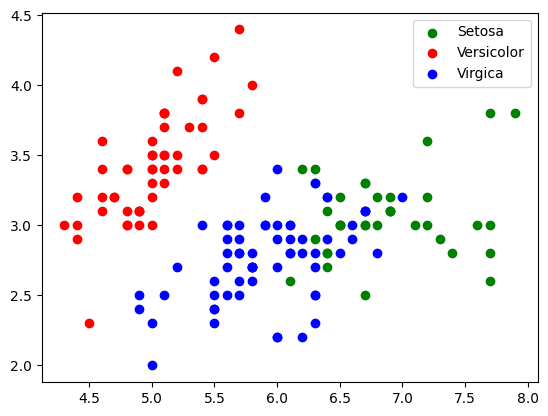

In [ ]:
# Plot
plt.scatter(iris.iloc[prev == 0, 0], iris.iloc[prev == 0, 1], c='green', label='Setosa')
plt.scatter(iris.iloc[prev == 1, 0], iris.iloc[prev == 1, 1], c='red', label='Versicolor')
plt.scatter(iris.iloc[prev == 2, 0], iris.iloc[prev == 2, 1], c='blue', label='Virgica')
plt.legend()
plt.show()

#### DBSCAN

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

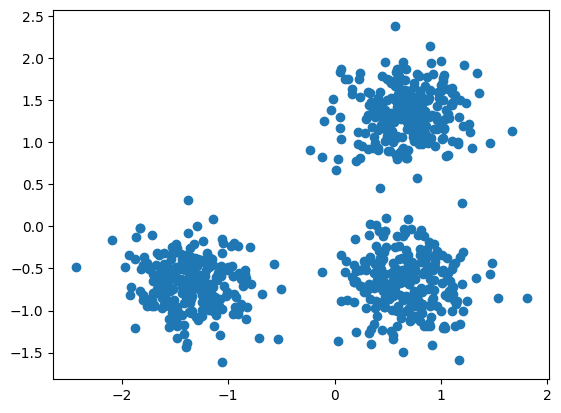

In [ ]:
# Use make_blobs to create 3 synthetic clusters
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.3)
X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [ ]:
# Create and train the model
cluster = DBSCAN(eps=0.3, min_samples=10) #min_samples is minPts
cluster.fit(X)

# Get measures
prev = labels = cluster.labels_ #-1 is outliers
unique_model, qty_model = np.unique(prev, return_counts=True)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

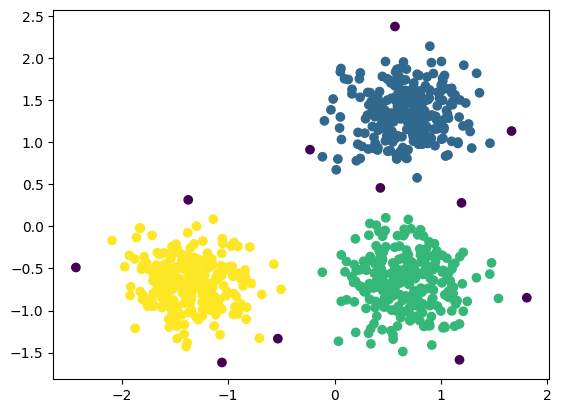

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=prev)
plt.show()

#### K-Medoids

In [ ]:
#!pip install scikit-learn-extra

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
# Create and train the model
cluster = KMedoids(n_clusters=3)
cluster.fit(iris.iloc[:,0:4])

# Get measures
centroides = cluster.cluster_centers_
prev = cluster.labels_
unique_model, qty_model = np.unique(prev, return_counts=True)

# Get Metrics
confusion = confusion_matrix(LabelEncoder().fit_transform(iris.iloc[:,4]), prev)
confusion

array([[ 0,  0, 50],
       [13, 37,  0],
       [49,  1,  0]])

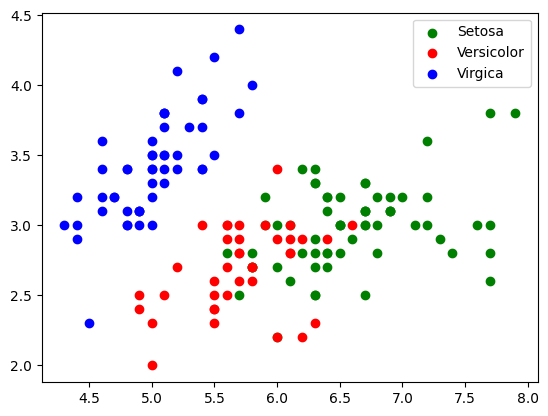

In [ ]:
# Plot
plt.scatter(iris.iloc[prev == 0, 0], iris.iloc[prev == 0, 1], c='green',label = 'Setosa')
plt.scatter(iris.iloc[prev == 1, 0], iris.iloc[prev == 1, 1], c='red',label = 'Versicolor')
plt.scatter(iris.iloc[prev == 2, 0], iris.iloc[prev == 2, 1], c='blue',label = 'Virgica')
plt.legend()
plt.show()

### Model Interpretation

#### Lime

Stands for Local Interpretable Model-agnostic Explanations.

Focuses on training local surrogate models to explain individual predictions. Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models.

Instead of training a global surrogate model, LIME focuses on training local surrogate models.

Is model-agnostic, meaning that it can be applied to any machine learning model. The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.

Tests what happens to the predictions when we provide variations in the data which is being fed into the machine learning model. This data variations is created by a permuting samples of data.

In [ ]:
from lime import lime_tabular
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
%%capture
is_class = True
if is_class:
  case_mode = 'classification'
  data, var_targetY = get_data_class(binary=True)
  X, y = data.drop(var_targetY, axis=1), data[[var_targetY]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  mdl = LogisticRegression().fit(X_train, y_train)
  predict_func = mdl.predict_proba
else:
  case_mode = 'regression'
  data, var_targetY = data_ml_reg, var_targetY_reg
  X, y = data.drop(var_targetY, axis=1), data[[var_targetY]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  mdl = LinearRegression().fit(X_train, y_train)
  predict_func = mdl.predict


In [ ]:
# Create Explainer object
explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns.values.tolist(),
    class_names = y.squeeze().unique(),
    mode = case_mode, verbose = True,
    categorical_features=None #list of indices corresponding to the categorical cols - the rest will be considered continuous
)

# to explain a certain prediction
exp = explainer.explain_instance(
    data_row = X_test.iloc[1],
    predict_fn = predict_func
)

# to show in notebook environment
exp.show_in_notebook(show_table=True) # or 'exp.as_list()'

Intercept 0.19586604991123732
Prediction_local [0.19724361]
Right: 0.1961647341979371


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### SHAP

Is a game-theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

Shap values, simply, are measures of contributions of each predictor (feature) has in a machine learning model. Each record/row will have n SHAP values, where n is the number of features.


Normally, not fit for categorical feature - can transform it using one-hot encodings. So, for each new feature generated by this transformation, a individual SHAP value is created, so it's get a hard to understand the overall contribution of the original categorical feature.

In [ ]:
%%capture
!pip install shap

In [ ]:
import shap
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split

In [ ]:
%%capture
is_class, is_binary = True, False
if is_class:
  data, var_targetY = get_data_class(binary=is_binary)
  X, y = data.drop(var_targetY, axis=1), data[[var_targetY]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  if is_binary:
    single_feature = 'product_name'
    mdl = XGBClassifier('reg:logistic').fit(X_train, y_train)
  else:
    single_feature = 'recommend_to_a_friend'
    mdl = XGBClassifier('multi:softprob').fit(X_train, y_train)
else:
  single_feature = 'GrLivArea'
  data, var_targetY = data_ml_reg, var_targetY_reg
  X, y = data.drop(var_targetY, axis=1), data[[var_targetY]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  mdl = XGBRegressor(objective="reg:squarederror").fit(X_train, y_train)

In [ ]:
# Create the explainer n calculate the shape values
##   For tree-based model: `shap.TreeExplaienr(mdl)`
##   For deep learning model: `shap.DeepExplaienr(mdl)`
##   For any model - like KNN: `shap.KernelExplaienr(mdl)`

explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# Explain single prediction - a condensed waterfall plot
##  f(x) is the prediction for that record
##  base value is the value that would be predicted if we didn't know any features for the current output
##  red indicates features that are pushing the prediction higher --- blue indicates just the opposite
##  If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction
##  If a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction

expected_val = explainer.expected_value
shap.initjs() # need because of the jupyter notebook

# Force Plot - single predictions
shap.force_plot(expected_val[0], shap_values[0])

# Stacked force plot - for multiples predictions
#shap.force_plot(expected_val, shap_values[0:100])

# Decision Plot - single predictions, there are many features
##  values in parenthesis are the values of the variables in the record
##  the vertical line in the center is the base value
#shap.decision_plot(expected_val, shap_values[0], X_test)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


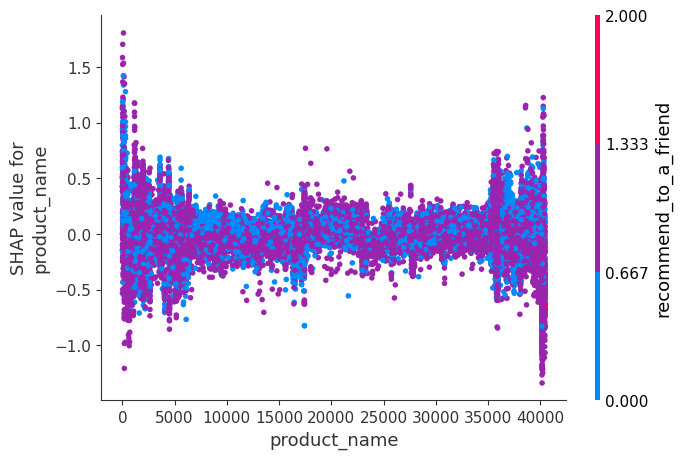

In [ ]:
# Dependence Plot - Global Interpretability
##  show how much important it is for the model
##  represent the relantionship between the defined variable and the target
##  the function automatically includes another var that the defined var interacts most with
single_feature='product_name'
shap.dependence_plot(single_feature, shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


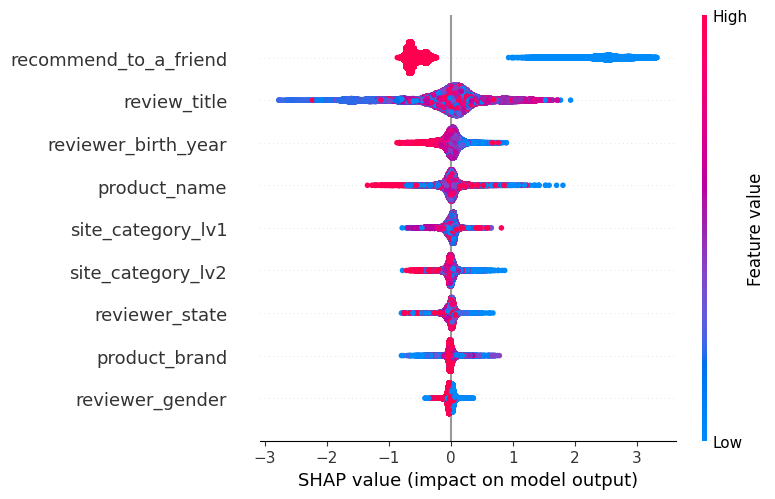

In [ ]:
# Variable Importance Plot - Global Interpretability
##  features are ranked in descending order - most importants in overall
##  in horizontal, shows the effect of that record in the output
##  feature with red on the right of the horizontal are positive correlated
##  feature with blue on the right of the horizontal are negative correlated
##  bar plot for mean SHAP - `shap.summary_plot(shap_values, X, plot_type="bar")`

shap.summary_plot(shap_values, X)

In [ ]:
# Others plots
shap_values = explainer(X)

shap.plots.bar(shap_values)          # Bar plot - similar to `summary_plot(plot_type="bar")`
shap.plots.bar(shap_values[0])          # Bar plot - for a single observation
shap.plots.beeswarm(shap_values)     # Beeswarm plot - similar to `summary_plot`
shap.plots.waterfall(shap_values[0]) # Waterfall plot for a observation
shap.plots.heatmap(shap_values[:50]) # Headmap plot for multiples observation - features in order of importance
shap.plots.scatter(shap_values[:,single_feature])

shap.plots.bar(shap_values.cohorts(2).abs.mean(0)) # Bar plot, but separate the data in 2 groups, the threshold is show in the figure


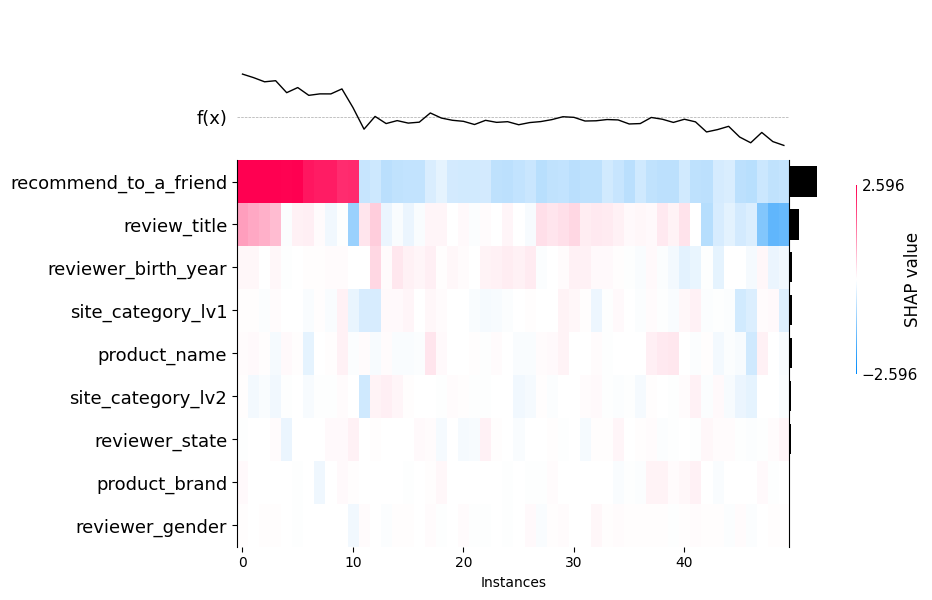

In [ ]:
shap.initjs()

#shap_values = explainer(X)
shap.plots.heatmap(shap_values[:50]) # Headmap plot for multiples observation - features in order of importance


## *Artificial Neural Network*

See lib ANN Visualizer: permite a visualização de redes neurais - ver o quão boa fica

### Simple

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np
#import tensorflow

In [ ]:
# Data
base = datasets.load_iris()
X = base['data']
y = base['target']

# Create dummy data
classe_dummy = np_utils.to_categorical(y)

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, classe_dummy, test_size=0.3, random_state=0)

# Create a sequential model and its leayrs
modelo = Sequential()
modelo.add(Dense(units=5, input_dim=4))
modelo.add(Dense(units=4))
modelo.add(Dense(units=3, activation='softmax'))

# Compile and train the network
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelo.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))

# Prevision
prev = modelo.predict(x_test)
prev = (prev > 0.5)

# Metrics
y_teste_matrix = [np.argmax(t) for t in y_test]
y_prev_matrix = [np.argmax(t) for t in prev]
confusion = confusion_matrix(y_teste_matrix,y_prev_matrix)
confusion

Epoch 1/1000
4/4 [==============================] - 2s 145ms/step - loss: 1.2213 - accuracy: 0.3714 - val_loss: 1.2602 - val_accuracy: 0.2222
Epoch 2/1000
4/4 [==============================] - 0s 21ms/step - loss: 1.1636 - accuracy: 0.3524 - val_loss: 1.1632 - val_accuracy: 0.2222
Epoch 3/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.1123 - accuracy: 0.3238 - val_loss: 1.1040 - val_accuracy: 0.2222
Epoch 4/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.0854 - accuracy: 0.3143 - val_loss: 1.0559 - val_accuracy: 0.4000
Epoch 5/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.0620 - accuracy: 0.3619 - val_loss: 1.0217 - val_accuracy: 0.4222
Epoch 6/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.0399 - accuracy: 0.3905 - val_loss: 1.0002 - val_accuracy: 0.4222
Epoch 7/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.0191 - accuracy: 0.3810 - val_loss: 0.9770 - val_accuracy: 0.4222
Epoch 8/1000

array([[16,  0,  0],
       [ 0, 17,  1],
       [ 0,  0, 11]])

### Deep Learning

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist
import numpy as np


11490434/11490434 [==============================] - 0s 0us/step


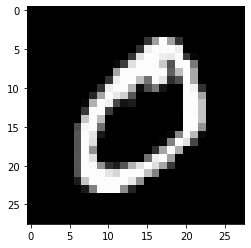

In [ ]:
# show data - images
(data, _),(_, _) = mnist.load_data()
plt.imshow(data[1],cmap='gray')
plt.show()

In [ ]:
# Split data
(x_train, y_treino), (x_test, y_test) = mnist.load_data()

# Data reshape - matrix became a list
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Change data type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Values between 0 and 255
x_train /= 255
x_test /= 255

# Convert to dummy variables
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Create a sequential model and its layers
modelo = Sequential()
modelo.add(Dense(units=64,activation='relu', input_dim=784))
modelo.add(Dropout(0.2)) #zera 20% dos neuronios
modelo.add(Dense(units=64,activation='relu'))
modelo.add(Dropout(0.2)) #zera 20% dos neuronios
modelo.add(Dense(units=64,activation='relu'))
modelo.add(Dropout(0.2)) #zera 20% dos neuronios
modelo.add(Dense(units=10, activation='softmax'))

# Compile and train the network
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico = modelo.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Prevision
prev = modelo.predict(x_test)

# Metrics
y_teste_matrix = [np.argmax(t) for t in y_test]
y_prev_matrix = [np.argmax(t) for t in prev]
confusao = confusion_matrix(y_teste_matrix,y_prev_matrix)